<a href="https://colab.research.google.com/github/mytran2111/NLP_tweet_disaters/blob/main/BERT_Tweet_Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install kaggle

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [3]:
! kaggle competitions download -c nlp-getting-started

  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 66.1MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 132MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 22.3MB/s]


In [4]:
# pip install sentencepiece
# pip install tensorflow-hub

import tensorflow as tf
import tensorflow_hub as hub

In [5]:
# Import Libraries 
import pandas as pd
import numpy as np
# For cleaning the text
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import regex as re
import string

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)

# For building our model
import tensorflow.keras
import sklearn
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D

In [6]:
# Getting the data 
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

Data Analysis

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


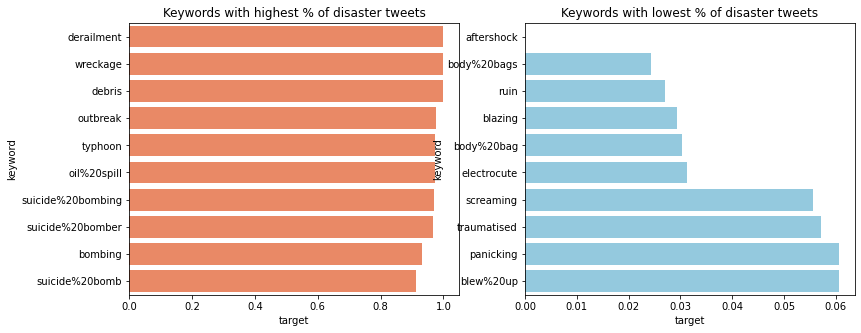

In [7]:
# Keywords with highest proportion 
top_disaster = train.groupby('keyword').mean()['target'].sort_values(ascending=False).head(10)
top_non_disaster = train.groupby('keyword').mean()['target'].sort_values().head(10)

plt.figure(figsize=(13,5))
plt.subplot(121)
sns.barplot(top_disaster, top_disaster.index, color='coral')
plt.title('Keywords with highest % of disaster tweets')
plt.subplot(122)
sns.barplot(top_non_disaster, top_non_disaster.index, color='skyblue')
plt.title('Keywords with lowest % of disaster tweets')
plt.show()

Data Cleaning

In [8]:
test_str = train.loc[417, 'text']

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to both train and test datasets
train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))

BERT and Word Embeddings

In [9]:
 #Bert Tokenizer for all of them
!pip install sentencepiece
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
import tokenization
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint


     |████████████████████████████████| 1.1MB 9.5MB/s 


In [ ]:
# # Try out the embeddings
# tester_sentence = "Terrorist will come to New York city"
# print('Tokenized version of {} is : \n {} '.format(tester_sentence, tokenizer.tokenize(tester_sentence)))

In [10]:
def bert_encode(texts, tokenizer, max_len=512): 
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [11]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    
    if Dropout_num == 0:
        # Without Dropout
        out = Dense(1, activation='sigmoid')(clf_output)
    else:
        # With Dropout(Dropout_num), Dropout_num > 0
        x = Dropout(Dropout_num)(clf_output)
        out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

Model Construction 

In [12]:
# parameters
Max_length = 42
Dropout_num = 0  
learning_rate = 6e-6 
valid = 0.2
epochs_num = 3
batch_size_num = 16
ids_error_corrected = True

In [13]:
# Load BERT from the Tensorflow Hub
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

# Load tokenizer from the bert layer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [14]:
# Try out the embeddings
tester_sentence = "Terrorist will come to New York city"
print('Tokenized version of {} is : \n {} '.format(tester_sentence, tokenizer.tokenize(tester_sentence)))

Tokenized version of Terrorist will come to New York city is : 
 ['terrorist', 'will', 'come', 'to', 'new', 'york', 'city'] 


In [15]:
# Encode the text into tokens, masks, and segment flags  
train_input = bert_encode(train['text'].values, tokenizer, max_len=42)
test_input = bert_encode(test['text'].values, tokenizer, max_len=42)
train_labels = train['target'].values

In [16]:
# Build BERT model with my tuning
model = build_model(bert_layer, max_len=42)  
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 42)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 42)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 42)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [17]:
# Train BERT model with my tuning
checkpoint = ModelCheckpoint('model_BERT.h5', monitor='val_loss', save_best_only=True)

train_history = model.fit(
    train_input, train_labels,
    validation_split = valid,
    epochs = epochs_num, # recomended 3-5 epochs
    callbacks=[checkpoint],
    batch_size = batch_size_num
)

Epoch 1/3
381/381 [==============================] - 6855s 18s/step - loss: 0.4911 - accuracy: 0.7746 - val_loss: 0.3847 - val_accuracy: 0.8306
Epoch 2/3
381/381 [==============================] - 6803s 18s/step - loss: 0.2769 - accuracy: 0.8878 - val_loss: 0.4101 - val_accuracy: 0.8240
Epoch 3/3
381/381 [==============================] - 6815s 18s/step - loss: 0.1218 - accuracy: 0.9596 - val_loss: 0.5183 - val_accuracy: 0.8129


In [19]:
model.load_weights('model_BERT.h5')

# for the testing data
test_pred = model.predict(test_input)
test_pred_int = test_pred.round().astype('int')

In [20]:
# Save model 
model.save('model_bert.h5')

In [22]:
# Submission by BERT
sample_submission['target'] = test_pred_int
sample_submission.to_csv("submission_final.csv", index=False)